<a href="https://colab.research.google.com/github/software-artisan/computer_vision_eva6_tsai/blob/main/session_6_normalization_and_regularization/assignment_6_batch_norm_regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
from collections import OrderedDict
import os
import sys
import shutil
import glob
import pdb

#print(f"os.getcwd()={os.getcwd()}")
#print(f"sys.path={sys.path}")

from google.colab import drive
drive.mount("/content/drive")

# copy .py files from google drive to local directory.. this will make the import easier (and this same code can be run from github as well,  where the files will be local, after commenting out the above drive code)
# shutil.copytree(dirs_exist_ok=True) not available in python 3.7 (the colab python version).
# shutil.copytree("/content/drive/MyDrive/tsai_eva6/assignment_6_files", ".",  )
for filename in glob.glob(os.path.join("/content/drive/MyDrive/tsai_eva6/assignment_6_files", '*.*')):
    print(f"copying filename={filename} to directory .")
    shutil.copy(filename, ".")

#!ls drive/MyDrive/tsai_eva6/assignment_6_files
#!ls .

import assignment_6_model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
copying filename=/content/drive/MyDrive/tsai_eva6/assignment_6_files/assignment_6_model.py to directory .


In [2]:
def get_norm_layer_orig( norm_layer_type, num_channels, num_groups_for_group_norm=None):
    """
    norm_layer_type: 'batch' | 'group' | 'layer'
    num_channels: # of channels
    """
    if norm_layer_type == "batch":
        # Applies Batch Normalization over a 4D input (a mini-batch of 2D inputs with additional channel dimension) as described in the paper Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift <https://arxiv.org/abs/1502.03167>__ .        #
        # The mean and standard-deviation are calculated per-dimension over the mini-batches and \gamma and \beta are learnable parameter vectors of size C (where C is the input size). By default, the elements of \gamma are set to 1 and the elements of \beta are set to 0. The standard-deviation is calculated via the biased estimator, equivalent to torch.var(input, unbiased=False).        #
        # def __init__(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        nl = nn.BatchNorm2d(num_features=num_channels)
    elif norm_layer_type == "group":
        # Applies Group Normalization over a mini-batch of inputs as described in the paper Group Normalization
        # The input channels are separated into num_groups groups, each containing num_channels / num_groups channels. The mean and standard-deviation are calculated separately over the each group. \gammaγ and \betaβ are learnable per-channel affine transform parameter vectors of size num_channels if affine is True. The standard-deviation is calculated via the biased estimator, equivalent to torch.var(input, unbiased=False).
        nl = nn.GroupNorm(num_groups=num_groups_for_group_norm, num_channels=num_channels)
    elif norm_layer_type == "layer":
        # a group size of '1' uses all the 'features'/channels of the image: essentially a 'layer norm'
        nl = nn.GroupNorm(num_groups=1, num_channels=num_channels)

    return nl

In [3]:
class NetOrig(nn.Module):
    def __init__(self, norm_layer_type, num_groups_for_group_norm=None):
        """
        norm_layer_type: 'batch' | 'group' | 'layer'
        """
        super(Net, self).__init__()
        
        dropout=0.05
 
        ####### 
        # Convolution Block #1
        #########
        self.conv1_1_3_3_8_p = nn.Sequential(OrderedDict([
            ('conv1_1_3_3_8_p', nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1, bias=False)),
            ('relu', nn.ReLU()),
            ('batchNorm2d', get_norm_layer(norm_layer_type, num_channels=8, num_groups_for_group_norm=num_groups_for_group_norm) ),
            ('dropOut2d', nn.Dropout2d(p=dropout))
          ])
        ) # Input=28, Output=28, rf=3

        self.conv2_8_3_3_8_p = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            get_norm_layer(norm_layer_type, num_channels=8, num_groups_for_group_norm=num_groups_for_group_norm),
            nn.Dropout2d(p=dropout)
        ) # Input=28, Output=28, rf=5
 
        self.conv3_8_3_3_8_p = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            get_norm_layer(norm_layer_type, num_channels=8, num_groups_for_group_norm=num_groups_for_group_norm),
            nn.Dropout2d(p=dropout) 
        ) # Input=28, Output=28, rf=10
 
        ####### 
        # Transition Block #1
        #########
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2) # Input=28, Output=14, rf=6
 
        self.conv4_8_1_1_12 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=1, padding=0, bias=False),
        ) # Input=14, Output=14, rf=32
 
        ####### 
        # Convolution Block #2
        #########
        self.conv5_12_3_3_11 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            get_norm_layer(norm_layer_type, num_channels=12, num_groups_for_group_norm=num_groups_for_group_norm),
            nn.Dropout2d(p=dropout)
        ) # Input=14, Output=14, rf=14
 
        self.conv6_11_3_3_12 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            get_norm_layer(norm_layer_type, num_channels=12, num_groups_for_group_norm=num_groups_for_group_norm),
            nn.Dropout2d(p=dropout) 
        ) # Input=14, Output=14, rf=24
        
        self.conv7_12_3_3_12 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            get_norm_layer(norm_layer_type, num_channels=12, num_groups_for_group_norm=num_groups_for_group_norm),
            nn.Dropout2d(p=dropout) 
        )# Input=14, Output=14, rf=24
        
        self.conv8_12_3_3_12 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            get_norm_layer(norm_layer_type, num_channels=12, num_groups_for_group_norm=num_groups_for_group_norm),
            nn.Dropout2d(p=dropout) 
        ) # Input=14, Output=14, rf=24

        self.conv9_12_3_3_12 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            get_norm_layer(norm_layer_type, num_channels=10, num_groups_for_group_norm=num_groups_for_group_norm),
            #nn.Dropout2d(p=dropout) 
        ) # Input=14, Output=14, rf=24
        
        #######
        # Transition block #2
        #######
        self.maxpool2= nn.MaxPool2d(kernel_size=2, stride=2) # Input=6, Output=3, chan=12, 
 
        ####### 
        # Output Block
        #########
        # global average pool before 1x1 to reduce computation
        #self.global_avgpool = nn.AdaptiveAvgPool2d(output_size=1)  # Input=3, Output=1, chan=12,
        self.global_avgpool = nn.AvgPool2d(kernel_size=10)  # Input=3, Output=1, chan=12,
 
        self.conv10_16_1_1_10 = nn.Sequential(
            #nn.Conv2d(in_channels=14, out_channels=10, kernel_size=3, padding=0, bias=False),
            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=1, padding=0, bias=False),
        ) # Input=1, Output=1, chan=10, 
    
    def forward(self, x):
        #####
        # conv block #1
        ########
        x = self.conv1_1_3_3_8_p(x)
        x = self.conv2_8_3_3_8_p(x)
        x = self.conv3_8_3_3_8_p(x)
 
        #####
        # Transitioni block #1
        ########
        x = self.maxpool1(x)
        x = self.conv4_8_1_1_12(x)
 
        #####
        # conv block #2
        ########
        x = self.conv5_12_3_3_11(x)
        x = self.conv6_11_3_3_12(x)
        x = self.conv7_12_3_3_12(x)
        x = self.conv8_12_3_3_12(x)
        x = self.conv9_12_3_3_12(x)

        #######
        # Transition block #2
        #######
        #x = self.maxpool2(x)
 
        #####
        # output block
        ########
        x = self.global_avgpool(x)        
        #x = self.conv10_16_1_1_10(x)
               
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [4]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = assignment_6_model.Net('batch').to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
         Dropout2d-4            [-1, 8, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             576
              ReLU-6            [-1, 8, 28, 28]               0
       BatchNorm2d-7            [-1, 8, 28, 28]              16
         Dropout2d-8            [-1, 8, 28, 28]               0
            Conv2d-9            [-1, 8, 28, 28]             576
             ReLU-10            [-1, 8, 28, 28]               0
      BatchNorm2d-11            [-1, 8, 28, 28]              16
        Dropout2d-12            [-1, 8, 28, 28]               0
        MaxPool2d-13            [-1, 8, 14, 14]               0
           Conv2d-14           [-1, 12,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/content/assignment_6_model.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [5]:
# SEED=1 so that we use the same random images for training, during each mini batch, during each epoch
SEED=1
torch.manual_seed(SEED)

batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# download training data set: 50,000 images
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-7.0, 7.0), fill=(1,)),

                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

# download test data set: 10,000 images
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
from tqdm import tqdm
from dataclasses import dataclass
from typing import Any

@dataclass
class TrainTestLossAccuracy:
    # test loss for each epoch
    test_loss_list:list
    # test accuracy for each epoch
    test_acc_list:list
    # training loss for each epoch
    train_loss_list:list
    # training accuracy for each epoch
    train_acc_list:list
    # list of tuples; each tuple is { incorrect_image, correct_class }
    incorrect_image_correct_class_tuples:list


def train_one_epoch(epoch, model, device, train_loader, optimizer, train_test_loss_acc:TrainTestLossAccuracy, lambda_l1=None, num_batches=None ):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  
  #loss_epoch:torch.Tensor=None
  loss_epoch:float=None

  for batch_idx, (data, y_target) in enumerate(pbar):
    # get samples of 'batchsize'        
    data, y_target = data.to(device), y_target.to(device)  # (Pdb) p data.shape=torch.Size([128, 1, 28, 28]); #(Pdb) y_target.shape = torch.Size([128])

    # So zero out the gradients before starting backpropragation because, without this, PyTorch accumulates gradients on subsequent backward passes. 
    optimizer.zero_grad()

    # predict
    y_pred = model(data)     # (Pdb) y_pred.shape = torch.Size([128, 10])

    # Calculate loss
    # input – (N, C) where N=<batch size> and C = number of classes or (N, C, H, W) in case of 2D Loss, or (N, C, d_1, d_2, ..., d_K)....
    # target – (N) where N=<batch size> and each value is 0 < targets[i] < C-1. ...
    loss = F.nll_loss(y_pred, y_target)     # negative log likelihood; this is a 1x1 tensor; see below
    # print(f"repr(loss)={repr(loss)}; loss.size()={loss.size()}") # repr(loss)=tensor(2.4530, grad_fn=<NllLossBackward>);  tensor(2.3594, grad_fn=<AddBackward0>)

    # if l1 regularization applies, do it..
    if lambda_l1:
      l1_loss = 0
      for p in model.parameters():
        l1_loss = l1_loss + p.abs().sum()
      loss = loss + lambda_l1 * l1_loss    # add l1 loss..

    #import pdb; pdb.set_trace()
    if not loss_epoch: 
      # loss_epoch = loss.clone().detach(); # if clone().detach() is not used, then loss_epoch and loss point to the same underlying tensor, which is not what we want; we want a copy; in addition, we do not want loss_epoch to participate in the compuation graph computed by pytorch
      loss_epoch = loss.item()
    else:
      #loss_epoch = loss_epoch + loss
      loss_epoch = loss_epoch + loss.item()
    
    #print(f"repr(loss_epoch)={repr(loss_epoch)}; loss_epoch.size()={loss_epoch.size()}")   # tensor(2.3594, grad_fn=<AddBackward0>)
    #print(f"repr(loss_epoch)={repr(loss_epoch)}; ")
    #print(f"repr(loss)={repr(loss)}; loss.size()={loss.size()}")

    loss.backward()  # do backpropagation across the graph:  dho(loss)/dho(weight)
    optimizer.step() # adjust the weights

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max element
    correct += pred.eq(y_target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Train phase: Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    # breaking out early is useful for debugging other code: set num_batches==1 so that we finish this loop quicker instead of waiting for several seconds..
    # if num_batches is defined and batch_idx == num_batches, then exit this loop
    if num_batches and batch_idx == num_batches: break
  
  #loss_epoch /= len(train_loader.dataset)
  train_test_loss_acc.train_loss_list.append(loss_epoch)
  train_test_loss_acc.train_acc_list.append(100*correct/processed)

  return train_test_loss_acc


def test_one_epoch(epoch, model, device, test_loader, train_test_loss_acc:TrainTestLossAccuracy, num_batches=None, capture_incorrects=False):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (data, y_target) in enumerate(test_loader):
            data_cpu = data
            y_target_cpu = y_target
            data, y_target = data.to(device), y_target.to(device);  # y_target=torch.Size([128]); data.shape=torch.Size([128, 1, 28, 28]); y_target[0]=tensor(4)
            output = model(data)    # output=torch.Size([128, 10]); output[0]=tensor([-2.6445, -1.7872, -2.3248, -2.5212, -2.5925, -2.5091, -2.1630, -2.1438,-2.2522, -2.4100])
            test_loss += F.nll_loss(output, y_target, reduction='sum').item()  # sum up batch loss            
            pred = output.argmax(dim=1, keepdim=True)  #pred=torch.Size([128, 1]);  get the index of the max log-probability
            correct_vector = pred.eq(y_target.view_as(pred))  #correct_vector.shape=torch.Size([128, 1]); correct_vector=tensor([[False], [False], [False],...])
            correct += correct_vector.sum().item()   

            # if need to identify the incorrect images and number of identified incorrect images < 20
            if capture_incorrects and len(train_test_loss_acc.incorrect_image_correct_class_tuples) < 20: 
              for i in range(len(correct_vector)):
                if not correct_vector[i]:   # our prediction did not match the actual class
                  train_test_loss_acc.incorrect_image_correct_class_tuples.append((data_cpu[i],pred[i], y_target_cpu[i]))  # store the pair { incorrect image, correct class }

            # breaking out early is useful for debugging other code: set num_batches==1 so that we finish this loop quicker instead of waiting for several seconds..
            # if num_batches is defined and batch_idx == num_batches, then exit this loop
            if num_batches and batch_idx >= num_batches: break

    test_loss /= len(test_loader.dataset)
    train_test_loss_acc.test_loss_list.append(test_loss)

    print(f'\nTest phase: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.2f}%)\n')
    if capture_incorrects: print(f"Number of incorrect images collected during test phase: {len(train_test_loss_acc.incorrect_image_correct_class_tuples)}")
    
    train_test_loss_acc.test_acc_list.append(100. * correct / len(test_loader.dataset))

In [7]:
from torch.optim.lr_scheduler import StepLR

def run_train_and_test(num_epochs, norm_type, num_groups_for_group_norm=None, lambda_l1=None, lambda_l2=None, num_batches=None) -> TrainTestLossAccuracy: 
  model =  assignment_6_model.Net(norm_layer_type=norm_type, num_groups_for_group_norm=num_groups_for_group_norm).to(device)
  
  if lambda_l2:
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=lambda_l2)
  else:
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
  
  scheduler = StepLR(optimizer, step_size=3, gamma=0.09)   # after the specified 'step_size', scale(multiply) the current LR by the specified gamma..
  
  train_test_loss_acc = TrainTestLossAccuracy([],[],[],[],[])
  for epoch in range(num_epochs):
      print("Epoch:", epoch+1)
      train_one_epoch(epoch, model, device, train_loader, optimizer, train_test_loss_acc, lambda_l1, num_batches=num_batches)
      test_one_epoch(epoch, model, device, test_loader, train_test_loss_acc, num_batches=num_batches, capture_incorrects=(epoch+1==num_epochs))
      scheduler.step()
  
  return train_test_loss_acc

In [8]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

def plot_incorrect_images(incorrect_image_correct_class_tuples:list):
  fig:matplotlib.figure.Figure = plt.figure(figsize=(10,12))   # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html#matplotlib.pyplot.figure
  fig.tight_layout()
  

  for i, (img, pred, correct) in enumerate(incorrect_image_correct_class_tuples[:20]):
          #img, pred, target = img.cpu().numpy(), pred.cpu(), correct.cpu()
          img = img.numpy()
          
          #img = np.transpose(img, (1, 2, 0)) / 2 + 0.5
          img = np.squeeze(img)   # convert 1x28x28 to 28x28
          # Three integers (nrows, ncols, index). The subplot will take the index position on a grid with nrows rows and ncols columns. index starts at 1 in the upper left corner and increases to the right. index can also be a two-tuple specifying the (first, last) indices (1-based, and including last) of the subplot, e.g., fig.add_subplot(3, 1, (1, 2)) makes a subplot that spans the upper 2/3 of the figure.
          ax:AxesSubPlot = fig.add_subplot(5, 5, i+1)   # https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure.add_subplot
          ax.axis('off')
          ax.set_title(f'\nactual : {correct.item()}\npredicted : {pred.item()}', fontsize=10)  
          ax.imshow(img)    # https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html#matplotlib.axes.Axes.imshow
  
  plt.show()

# Group Normalization + L1 Regularization (Train and Test)

  0%|          | 0/469 [00:00<?, ?it/s]

Training NN model with group normalization and layer1 regularization
Epoch: 1


/content/assignment_6_model.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
Train phase: Loss=0.30514535307884216 Batch_id=468 Accuracy=83.89: 100%|██████████| 469/469 [00:17<00:00, 27.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.1241, Accuracy: 9629/10000 (96.29%)

Epoch: 2


Train phase: Loss=0.20784562826156616 Batch_id=468 Accuracy=95.35: 100%|██████████| 469/469 [00:17<00:00, 27.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0754, Accuracy: 9777/10000 (97.77%)

Epoch: 3


Train phase: Loss=0.23818232119083405 Batch_id=468 Accuracy=96.28: 100%|██████████| 469/469 [00:17<00:00, 26.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0560, Accuracy: 9827/10000 (98.27%)

Epoch: 4


Train phase: Loss=0.20363007485866547 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:17<00:00, 27.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0390, Accuracy: 9882/10000 (98.82%)

Epoch: 5


Train phase: Loss=0.15336310863494873 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:17<00:00, 26.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0372, Accuracy: 9884/10000 (98.84%)

Epoch: 6


Train phase: Loss=0.18501131236553192 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:17<00:00, 27.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0350, Accuracy: 9893/10000 (98.93%)

Epoch: 7


Train phase: Loss=0.13257157802581787 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:17<00:00, 26.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0341, Accuracy: 9899/10000 (98.99%)

Epoch: 8


Train phase: Loss=0.18835031986236572 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:18<00:00, 25.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0339, Accuracy: 9900/10000 (99.00%)

Epoch: 9


Train phase: Loss=0.15330424904823303 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:18<00:00, 25.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0335, Accuracy: 9896/10000 (98.96%)

Epoch: 10


Train phase: Loss=0.13910043239593506 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:18<00:00, 26.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0334, Accuracy: 9897/10000 (98.97%)

Epoch: 11


Train phase: Loss=0.17493508756160736 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:17<00:00, 26.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0335, Accuracy: 9896/10000 (98.96%)

Epoch: 12


Train phase: Loss=0.1522420346736908 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:17<00:00, 26.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0335, Accuracy: 9896/10000 (98.96%)

Epoch: 13


Train phase: Loss=0.1637684404850006 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:17<00:00, 26.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0334, Accuracy: 9897/10000 (98.97%)

Epoch: 14


Train phase: Loss=0.19218283891677856 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:17<00:00, 26.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0334, Accuracy: 9897/10000 (98.97%)

Epoch: 15


Train phase: Loss=0.29068833589553833 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:17<00:00, 26.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0335, Accuracy: 9897/10000 (98.97%)

Epoch: 16


Train phase: Loss=0.14787925779819489 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:17<00:00, 26.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0335, Accuracy: 9897/10000 (98.97%)

Epoch: 17


Train phase: Loss=0.13248246908187866 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:17<00:00, 26.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0335, Accuracy: 9897/10000 (98.97%)

Epoch: 18


Train phase: Loss=0.17834755778312683 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:17<00:00, 26.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0335, Accuracy: 9897/10000 (98.97%)

Epoch: 19


Train phase: Loss=0.16657176613807678 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:17<00:00, 26.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0335, Accuracy: 9897/10000 (98.97%)

Epoch: 20


Train phase: Loss=0.1734563261270523 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:17<00:00, 26.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0335, Accuracy: 9897/10000 (98.97%)

Epoch: 21


Train phase: Loss=0.14887621998786926 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:17<00:00, 26.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0335, Accuracy: 9897/10000 (98.97%)

Epoch: 22


Train phase: Loss=0.12662269175052643 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:17<00:00, 26.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0335, Accuracy: 9897/10000 (98.97%)

Epoch: 23


Train phase: Loss=0.12904024124145508 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:17<00:00, 26.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0335, Accuracy: 9897/10000 (98.97%)

Epoch: 24


Train phase: Loss=0.1555950939655304 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:18<00:00, 25.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0335, Accuracy: 9897/10000 (98.97%)

Epoch: 25


Train phase: Loss=0.12928083539009094 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:18<00:00, 25.60it/s]



Test phase: Average loss: 0.0335, Accuracy: 9897/10000 (98.97%)

Number of incorrect images collected during test phase: 20
Incorrect image predictions for NN with group normalization and layer1 regularization


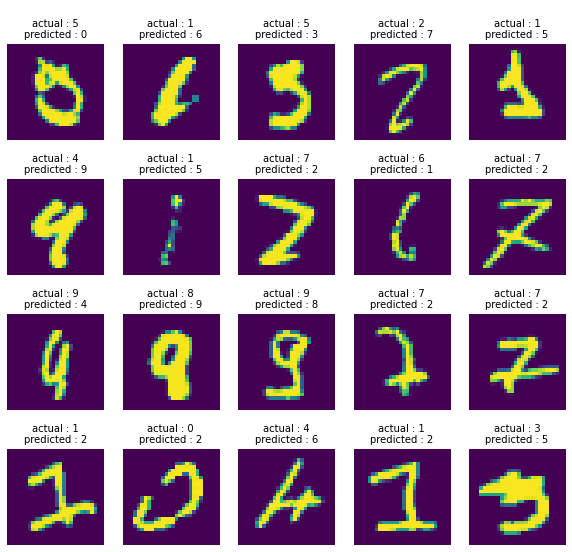

In [9]:
print(f"Training NN model with group normalization and layer1 regularization")
train_test_loss_acc_group:TrainTestLossAccuracy = run_train_and_test(num_epochs=25, norm_type='group', num_groups_for_group_norm=2, lambda_l1=0.0001) #, num_batches=1)
print(f"Incorrect image predictions for NN with group normalization and layer1 regularization")
plot_incorrect_images(train_test_loss_acc_group.incorrect_image_correct_class_tuples)

# Layer Normalization + L2 Regularization (train and test)

  0%|          | 0/469 [00:00<?, ?it/s]

Training NN model with layer normalization and layer2 regularization
Epoch: 1


/content/assignment_6_model.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
Train phase: Loss=0.10927000641822815 Batch_id=468 Accuracy=79.42: 100%|██████████| 469/469 [00:16<00:00, 27.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.1276, Accuracy: 9617/10000 (96.17%)

Epoch: 2


Train phase: Loss=0.1855887919664383 Batch_id=468 Accuracy=94.64: 100%|██████████| 469/469 [00:17<00:00, 27.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0729, Accuracy: 9785/10000 (97.85%)

Epoch: 3


Train phase: Loss=0.14640310406684875 Batch_id=468 Accuracy=96.14: 100%|██████████| 469/469 [00:16<00:00, 27.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0553, Accuracy: 9825/10000 (98.25%)

Epoch: 4


Train phase: Loss=0.0933116152882576 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:17<00:00, 27.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0410, Accuracy: 9880/10000 (98.80%)

Epoch: 5


Train phase: Loss=0.07526858896017075 Batch_id=468 Accuracy=97.63: 100%|██████████| 469/469 [00:17<00:00, 27.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0404, Accuracy: 9877/10000 (98.77%)

Epoch: 6


Train phase: Loss=0.08886060863733292 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:17<00:00, 27.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0379, Accuracy: 9888/10000 (98.88%)

Epoch: 7


Train phase: Loss=0.040377940982580185 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:17<00:00, 27.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0378, Accuracy: 9889/10000 (98.89%)

Epoch: 8


Train phase: Loss=0.0958656445145607 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:17<00:00, 27.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0379, Accuracy: 9886/10000 (98.86%)

Epoch: 9


Train phase: Loss=0.04520183429121971 Batch_id=468 Accuracy=97.85: 100%|██████████| 469/469 [00:16<00:00, 27.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0373, Accuracy: 9886/10000 (98.86%)

Epoch: 10


Train phase: Loss=0.04683789610862732 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:16<00:00, 28.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0373, Accuracy: 9885/10000 (98.85%)

Epoch: 11


Train phase: Loss=0.10692289471626282 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:17<00:00, 27.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0373, Accuracy: 9887/10000 (98.87%)

Epoch: 12


Train phase: Loss=0.10643401741981506 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:16<00:00, 27.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0372, Accuracy: 9887/10000 (98.87%)

Epoch: 13


Train phase: Loss=0.06661459058523178 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:16<00:00, 27.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0372, Accuracy: 9887/10000 (98.87%)

Epoch: 14


Train phase: Loss=0.08745592087507248 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:16<00:00, 28.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0372, Accuracy: 9887/10000 (98.87%)

Epoch: 15


Train phase: Loss=0.06975383311510086 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:17<00:00, 27.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0372, Accuracy: 9887/10000 (98.87%)

Epoch: 16


Train phase: Loss=0.11240171641111374 Batch_id=468 Accuracy=97.82: 100%|██████████| 469/469 [00:17<00:00, 26.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0372, Accuracy: 9887/10000 (98.87%)

Epoch: 17


Train phase: Loss=0.02629692107439041 Batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:17<00:00, 27.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0372, Accuracy: 9887/10000 (98.87%)

Epoch: 18


Train phase: Loss=0.07583799213171005 Batch_id=468 Accuracy=97.85: 100%|██████████| 469/469 [00:17<00:00, 26.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0372, Accuracy: 9887/10000 (98.87%)

Epoch: 19


Train phase: Loss=0.05244627594947815 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:17<00:00, 27.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0372, Accuracy: 9887/10000 (98.87%)

Epoch: 20


Train phase: Loss=0.06501846015453339 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:17<00:00, 27.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0372, Accuracy: 9887/10000 (98.87%)

Epoch: 21


Train phase: Loss=0.060740817338228226 Batch_id=468 Accuracy=97.85: 100%|██████████| 469/469 [00:17<00:00, 26.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0372, Accuracy: 9887/10000 (98.87%)

Epoch: 22


Train phase: Loss=0.06550221890211105 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:17<00:00, 27.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0372, Accuracy: 9887/10000 (98.87%)

Epoch: 23


Train phase: Loss=0.12595327198505402 Batch_id=468 Accuracy=97.76: 100%|██████████| 469/469 [00:17<00:00, 26.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0372, Accuracy: 9887/10000 (98.87%)

Epoch: 24


Train phase: Loss=0.02072388492524624 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:17<00:00, 27.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0372, Accuracy: 9887/10000 (98.87%)

Epoch: 25


Train phase: Loss=0.08712917566299438 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [00:17<00:00, 27.02it/s]



Test phase: Average loss: 0.0372, Accuracy: 9887/10000 (98.87%)

Number of incorrect images collected during test phase: 20
Incorrect image predictions for NN with layer normalization and layer2 regularization


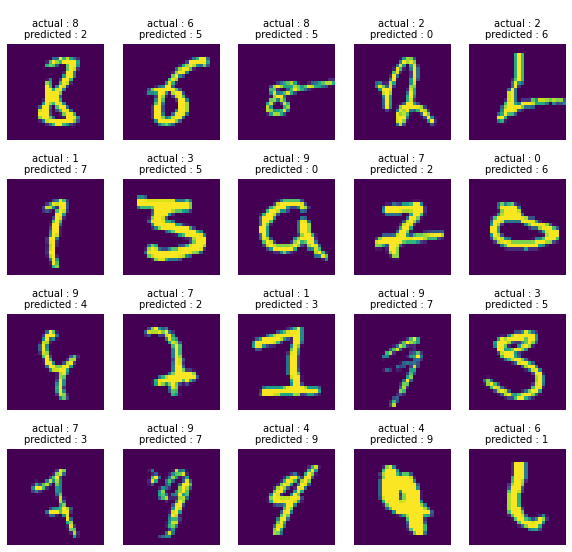

In [10]:
print(f"Training NN model with layer normalization and layer2 regularization")
train_test_loss_acc_layer:TrainTestLossAccuracy = run_train_and_test(num_epochs=25, norm_type='layer', lambda_l2=0.0001) #, num_batches=1)
print(f"Incorrect image predictions for NN with layer normalization and layer2 regularization")
plot_incorrect_images(train_test_loss_acc_layer.incorrect_image_correct_class_tuples)

# Batch Normalization + L1 + L2 Regularization (train and test)

  0%|          | 0/469 [00:00<?, ?it/s]

Training NN model with batch normalization, layer 1 and layer 2 regularization
Epoch: 1


/content/assignment_6_model.py:164: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
Train phase: Loss=0.21669882535934448 Batch_id=468 Accuracy=88.14: 100%|██████████| 469/469 [00:17<00:00, 26.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0970, Accuracy: 9722/10000 (97.22%)

Epoch: 2


Train phase: Loss=0.2172466516494751 Batch_id=468 Accuracy=95.55: 100%|██████████| 469/469 [00:18<00:00, 25.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0759, Accuracy: 9777/10000 (97.77%)

Epoch: 3


Train phase: Loss=0.28568750619888306 Batch_id=468 Accuracy=96.36: 100%|██████████| 469/469 [00:17<00:00, 26.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0529, Accuracy: 9851/10000 (98.51%)

Epoch: 4


Train phase: Loss=0.1614505797624588 Batch_id=468 Accuracy=97.54: 100%|██████████| 469/469 [00:17<00:00, 26.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0315, Accuracy: 9917/10000 (99.17%)

Epoch: 5


Train phase: Loss=0.13821467757225037 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:18<00:00, 25.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0307, Accuracy: 9914/10000 (99.14%)

Epoch: 6


Train phase: Loss=0.25649482011795044 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:17<00:00, 26.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0285, Accuracy: 9919/10000 (99.19%)

Epoch: 7


Train phase: Loss=0.13568581640720367 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:17<00:00, 26.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0285, Accuracy: 9917/10000 (99.17%)

Epoch: 8


Train phase: Loss=0.14875923097133636 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:18<00:00, 25.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0282, Accuracy: 9920/10000 (99.20%)

Epoch: 9


Train phase: Loss=0.13270510733127594 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:17<00:00, 26.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0277, Accuracy: 9920/10000 (99.20%)

Epoch: 10


Train phase: Loss=0.17174860835075378 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:17<00:00, 26.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0279, Accuracy: 9920/10000 (99.20%)

Epoch: 11


Train phase: Loss=0.1931842863559723 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:17<00:00, 26.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0279, Accuracy: 9922/10000 (99.22%)

Epoch: 12


Train phase: Loss=0.23844864964485168 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:17<00:00, 26.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0276, Accuracy: 9918/10000 (99.18%)

Epoch: 13


Train phase: Loss=0.16120746731758118 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:18<00:00, 25.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0279, Accuracy: 9917/10000 (99.17%)

Epoch: 14


Train phase: Loss=0.13966986536979675 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:18<00:00, 25.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0282, Accuracy: 9920/10000 (99.20%)

Epoch: 15


Train phase: Loss=0.15614330768585205 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:18<00:00, 25.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0273, Accuracy: 9920/10000 (99.20%)

Epoch: 16


Train phase: Loss=0.1455582082271576 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:18<00:00, 25.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0275, Accuracy: 9919/10000 (99.19%)

Epoch: 17


Train phase: Loss=0.21369612216949463 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:18<00:00, 26.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0275, Accuracy: 9920/10000 (99.20%)

Epoch: 18


Train phase: Loss=0.24393051862716675 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:17<00:00, 26.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0276, Accuracy: 9920/10000 (99.20%)

Epoch: 19


Train phase: Loss=0.12722985446453094 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:17<00:00, 26.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0280, Accuracy: 9918/10000 (99.18%)

Epoch: 20


Train phase: Loss=0.1400957852602005 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:18<00:00, 25.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0273, Accuracy: 9921/10000 (99.21%)

Epoch: 21


Train phase: Loss=0.1236644983291626 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:19<00:00, 24.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0274, Accuracy: 9921/10000 (99.21%)

Epoch: 22


Train phase: Loss=0.20968689024448395 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:18<00:00, 25.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0275, Accuracy: 9922/10000 (99.22%)

Epoch: 23


Train phase: Loss=0.1628108024597168 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:18<00:00, 26.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0281, Accuracy: 9919/10000 (99.19%)

Epoch: 24


Train phase: Loss=0.1936246156692505 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:17<00:00, 26.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test phase: Average loss: 0.0280, Accuracy: 9917/10000 (99.17%)

Epoch: 25


Train phase: Loss=0.1417277604341507 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:17<00:00, 26.35it/s]



Test phase: Average loss: 0.0276, Accuracy: 9919/10000 (99.19%)

Number of incorrect images collected during test phase: 21
Incorrect image predictions for NN with batch normalization, layer 1 and layer 2 regularization


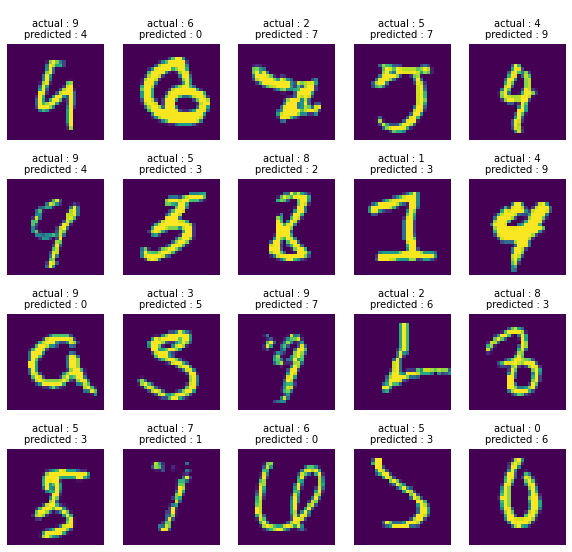

In [11]:
print(f"Training NN model with batch normalization, layer 1 and layer 2 regularization")
train_test_loss_acc_batch:TrainTestLossAccuracy = run_train_and_test(num_epochs=25, norm_type='batch', lambda_l1=0.0001, lambda_l2=0.0001) #, num_batches=1)
print(f"Incorrect image predictions for NN with batch normalization, layer 1 and layer 2 regularization")
plot_incorrect_images(train_test_loss_acc_batch.incorrect_image_correct_class_tuples)

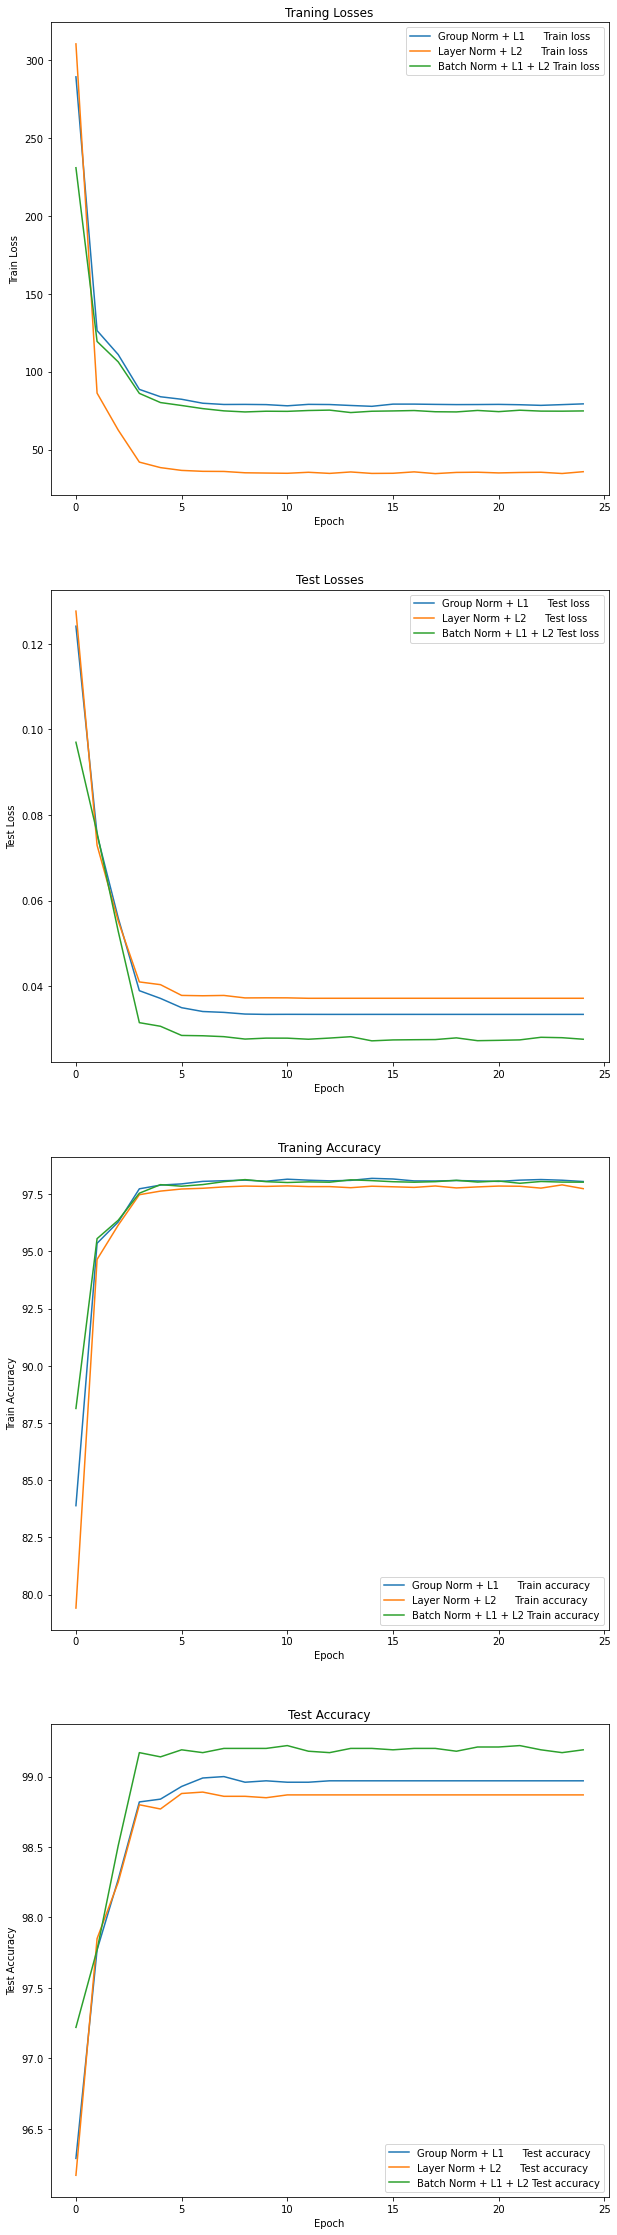

In [12]:
import matplotlib.pyplot as plt
def plot_train_test_loss_acc(train_test_loss_acc_group:TrainTestLossAccuracy, train_test_loss_acc_layer:TrainTestLossAccuracy, train_test_loss_acc_batch:TrainTestLossAccuracy):
    ax_train_loss:AxesSubplot; ax_test_loss:AxesSubplot; ax_train_acc:AxesSubplot; ax_test_acc:AxesSubplot;
    fig, (ax_train_loss, ax_test_loss,ax_train_acc,ax_test_acc) = plt.subplots(4,1, figsize=(10,40))

    ax_train_loss.plot(train_test_loss_acc_group.train_loss_list, label="Group Norm + L1      Train loss")
    ax_train_loss.plot(train_test_loss_acc_layer.train_loss_list, label="Layer Norm + L2      Train loss")
    ax_train_loss.plot(train_test_loss_acc_batch.train_loss_list, label="Batch Norm + L1 + L2 Train loss")
    ax_train_loss.legend()
    ax_train_loss.set_xlabel("Epoch")
    ax_train_loss.set_ylabel("Train Loss")
    ax_train_loss.set_title("Traning Losses")
    
    ax_test_loss.plot(train_test_loss_acc_group.test_loss_list, label="Group Norm + L1      Test loss")
    ax_test_loss.plot(train_test_loss_acc_layer.test_loss_list, label="Layer Norm + L2      Test loss")
    ax_test_loss.plot(train_test_loss_acc_batch.test_loss_list, label="Batch Norm + L1 + L2 Test loss")
    ax_test_loss.legend()
    ax_test_loss.set_xlabel("Epoch")
    ax_test_loss.set_ylabel("Test Loss")
    ax_test_loss.set_title("Test Losses")

    ax_train_acc.plot(train_test_loss_acc_group.train_acc_list, label="Group Norm + L1      Train accuracy")
    ax_train_acc.plot(train_test_loss_acc_layer.train_acc_list, label="Layer Norm + L2      Train accuracy")
    ax_train_acc.plot(train_test_loss_acc_batch.train_acc_list, label="Batch Norm + L1 + L2 Train accuracy")
    ax_train_acc.legend()
    ax_train_acc.set_xlabel("Epoch")
    ax_train_acc.set_ylabel("Train Accuracy")
    ax_train_acc.set_title("Traning Accuracy")

    ax_test_acc.plot(train_test_loss_acc_group.test_acc_list, label="Group Norm + L1      Test accuracy")
    ax_test_acc.plot(train_test_loss_acc_layer.test_acc_list, label="Layer Norm + L2      Test accuracy")
    ax_test_acc.plot(train_test_loss_acc_batch.test_acc_list, label="Batch Norm + L1 + L2 Test accuracy")
    ax_test_acc.legend()
    ax_test_acc.set_xlabel("Epoch")
    ax_test_acc.set_ylabel("Test Accuracy")
    ax_test_acc.set_title("Test Accuracy")
    
    # plt.xlabel("Epoch")
    # plt.ylabel("Accuracy")
    plt.show()

plot_train_test_loss_acc(train_test_loss_acc_group, train_test_loss_acc_layer, train_test_loss_acc_batch)
# plot_train_test_loss_acc(TrainTestLossAccuracy(range(0,15), range(0,15), range(0,15), range(0,15)), 
#                          TrainTestLossAccuracy(range(1,16), range(1,16), range(1,16), range(1,16)), 
#                          TrainTestLossAccuracy(range(2,17), range(2,17), range(2,17), range(2,17)))